In [1]:
## Daniel Marten
## TPM Plot Generation

import numpy as np
import pandas as pd
import sklearn
import colorsys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns
import statistics
import sys
import os
import statsmodels.api as sm
import statsmodels.stats.weightstats as sm_stats
import seaborn as sns
import scipy
import scipy.stats as scistats

from statsmodels.formula.api import ols as formula_OLS

from cmapPy.pandasGEXpress.parse_gct import parse as tpm_parser




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Read in GTEx Data - as downloaded via GTEx v8, but with some additional evolutionary information we've added
gtex_full = pd.read_csv('/Users/marten/Downloads/tpm_fulldata.tsv',sep='\t')
datename = '20231207'

In [3]:
# [sic] gtex_parsed, only selecting and renaming certain columns to remove unecessary metadata
#  and fit graphing scheme 
gtex_parsed = gtex_full[['ps','era5','brain','ecto','meso','endo','ovary','testis']]
gtex_parsed.rename(columns = {'ps':'PS',
                             'era5':'Era-5',
                             'brain':'1-Brain',
                             'ecto':'2-Ecto',
                             'meso':'3-Meso',
                             'endo':'4-Endo',
                             'ovary':'5-Ovary',
                             'testis':'6-Testis'},inplace=True)
gtex_parsed

/var/folders/29/nl14y27n0516tj91qh8q3njh0000gq/T/ipykernel_76336/1695189173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtex_parsed.rename(columns = {'ps':'PS',


,PS,Era-5,1-Brain,2-Ecto,3-Meso,4-Endo,5-Ovary,6-Testis
0,1,1-Ancient,142.352938,188.776200,147.951867,142.822250,153.442000,155.484000
1,2,1-Ancient,19.104769,41.330230,50.929719,41.748400,54.286100,58.175700
2,1,1-Ancient,21.427077,34.698790,41.231367,48.781800,11.673800,15.425100
3,1,1-Ancient,46.704162,55.318160,41.493533,39.069210,52.196600,83.716000
4,1,1-Ancient,11.990285,21.841623,6.671310,4.701098,6.277760,24.774700
...,...,...,...,...,...,...,...,...
19024,2,1-Ancient,0.000000,0.000000,0.000000,0.000000,0.000000,0.140301
19025,8,3-Chordate,0.025855,0.138997,0.098787,0.129226,0.134050,34.087300
19026,1,1-Ancient,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19027,1,1-Ancient,0.090274,0.276149,0.184655,0.146304,0.501492,0.272131


In [4]:
# Melted or 'tidy' version of gtex data, with one row for each observation (essentially)
dermTidy = pd.melt(frame=gtex_parsed,id_vars = ['PS','Era-5'],var_name='Derm',value_name='Mean(Count)',ignore_index=False)
dermTidy


,PS,Era-5,Derm,Mean(Count)
0,1,1-Ancient,1-Brain,142.352938
1,2,1-Ancient,1-Brain,19.104769
2,1,1-Ancient,1-Brain,21.427077
3,1,1-Ancient,1-Brain,46.704162
4,1,1-Ancient,1-Brain,11.990285
...,...,...,...,...
19024,2,1-Ancient,6-Testis,0.140301
19025,8,3-Chordate,6-Testis,34.087300
19026,1,1-Ancient,6-Testis,0.000000
19027,1,1-Ancient,6-Testis,0.272131


In [5]:
# Find smallest non-zero value by Tissue Category
smallest_derm_nonzero = min(dermTidy[dermTidy['Mean(Count)']>0]['Mean(Count)'])
dermTidy['Log10'] = np.log10([xi + smallest_derm_nonzero for xi in dermTidy['Mean(Count)']])
dermTidy['Log10']

0        2.153367
1        1.281144
2        1.330965
3        1.669357
4        1.078834
           ...   
19024   -0.852574
19025    1.532594
19026   -3.927974
19027   -0.565034
19028    0.983153
Name: Log10, Length: 114174, dtype: float64

In [6]:
smallest_derm_nonzero

0.0001180392307692

In [7]:
# Setting up color scheme, with additional work done later to make things POP for publication 
era_five_colours = {
    'Ancient':'blue',
    'Metazoan':'green',
    'Chordate':'orange',
    'Mammal':'purple',
    'Primate':'grey',
}


germ_colours = {
    'Brain':'#e377c2',
    'Ecto':'#ff7f0e',
    'Meso':'#d62728',
    'Endo':'#1f77b4',
    'Ovary':'#2ca02c',
    'Testis':'#9467bd'
}

import colorsys

rbg = None

def scale_lightness(rgb, scale_l, sat_in):
    # convert rgb to hls
    print(rbg)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    print('incoming saturation as: ',s)
    sat_out = s*sat_in
    if sat_out > 1.00:
        sat_out = 1.00
    print('outgoing saturation as: ',sat_out)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), sat_out)

In [8]:
# Actually makes colors more colorful

for key,val in germ_colours.items():
    print('Value as: ',val)
    color_in = matplotlib.colors.ColorConverter.to_rgb(val)
    germ_colours[key] = scale_lightness(color_in,1.15,1.25)

Value as:  #e377c2
None
incoming saturation as:  0.6585365853658535
outgoing saturation as:  0.8231707317073168
Value as:  #ff7f0e
None
incoming saturation as:  1.0
outgoing saturation as:  1.0
Value as:  #d62728
None
incoming saturation as:  0.691699604743083
outgoing saturation as:  0.8646245059288538
Value as:  #1f77b4
None
incoming saturation as:  0.7061611374407583
outgoing saturation as:  0.8827014218009478
Value as:  #2ca02c
None
incoming saturation as:  0.5686274509803921
outgoing saturation as:  0.7107843137254901
Value as:  #9467bd
None
incoming saturation as:  0.3944954128440367
outgoing saturation as:  0.4931192660550459


In [9]:
# Creates distinct different dataframes for each evolutionary category 
dfs_per_era = {}
for era_val in gtex_parsed['Era-5'].unique():
    dfs_per_era[era_val] = gtex_parsed[gtex_parsed['Era-5']==era_val]

In [10]:
# some string splitting for clear plotting
dermTidy['plot_era5'] = [dt5.split('-')[-1] for dt5 in dermTidy['Era-5']]
dermTidy['plot_era5'] = dermTidy['plot_era5'].replace('Metazoa','Metazoan')
dermTidy['plot_derm'] = [dtg.split('-')[-1] for dtg in dermTidy['Derm']]

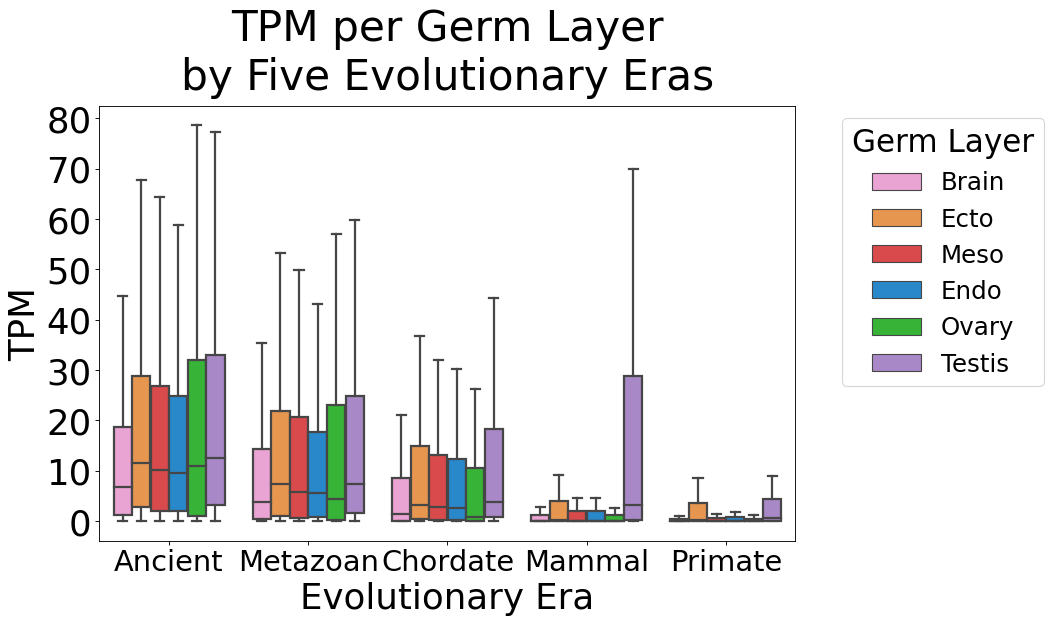

In [11]:
# PLOT SET #1 - Five era Configuration
plt.figure(figsize=(12,8), dpi=80)
sns.boxplot(data=dermTidy.sort_values(by=['Era-5','Derm']),x='plot_era5',y='Mean(Count)',hue='plot_derm',showfliers=False,linewidth=2 ,palette=germ_colours)
plt.xlabel('Evolutionary Era',size=32)
plt.ylabel('TPM',size=32)
xOnes,xTwos = plt.xticks()
xTwos[1] = "Metazoan"
plt.xticks(xOnes,xTwos,size=26)
plt.yticks(size=32)
plt.legend(title='Germ Layer',title_fontsize=28,fontsize=22,bbox_to_anchor=(1.05, 1))
plt.title('TPM per Germ Layer\nby Five Evolutionary Eras',size=38,pad=15)
plt.subplots_adjust(left=0.175,bottom=0.2)

image_name = f'fig1-tpm-per-germ-by-five-eras-metazoanlabelsize-{datename}'
plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/png/{image_name}_png.png',bbox_inches="tight")
plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/pdf/{image_name}_pdf.pdf',bbox_inches="tight")


plt.show()

In [12]:
# Further color tweaking
animalgreen = matplotlib.colors.ColorConverter.to_rgb('green')
animalgreen = scale_lightness(color_in,1.15,1.00)

None
incoming saturation as:  0.3944954128440367
outgoing saturation as:  0.3944954128440367


In [13]:
# modification of 'animalgreen' for Metazoan
animalgreen = matplotlib.colors.ColorConverter.to_rgb('green')
animalgreen = scale_lightness(animalgreen,1.15,1.00)
animalgreen

None
incoming saturation as:  1.0
outgoing saturation as:  1.0


(0.0, 0.5772549019607842, 0.0)

In [14]:
# inserting animal green into color dictionary 
era_five_colours = {
    'Ancient':"#ffff00",
    'Metazoan':animalgreen,
    'Chordate':"#F8766D",
    'Mammal':"#619CFF",
    'Primate':"#ff7f0e"
}

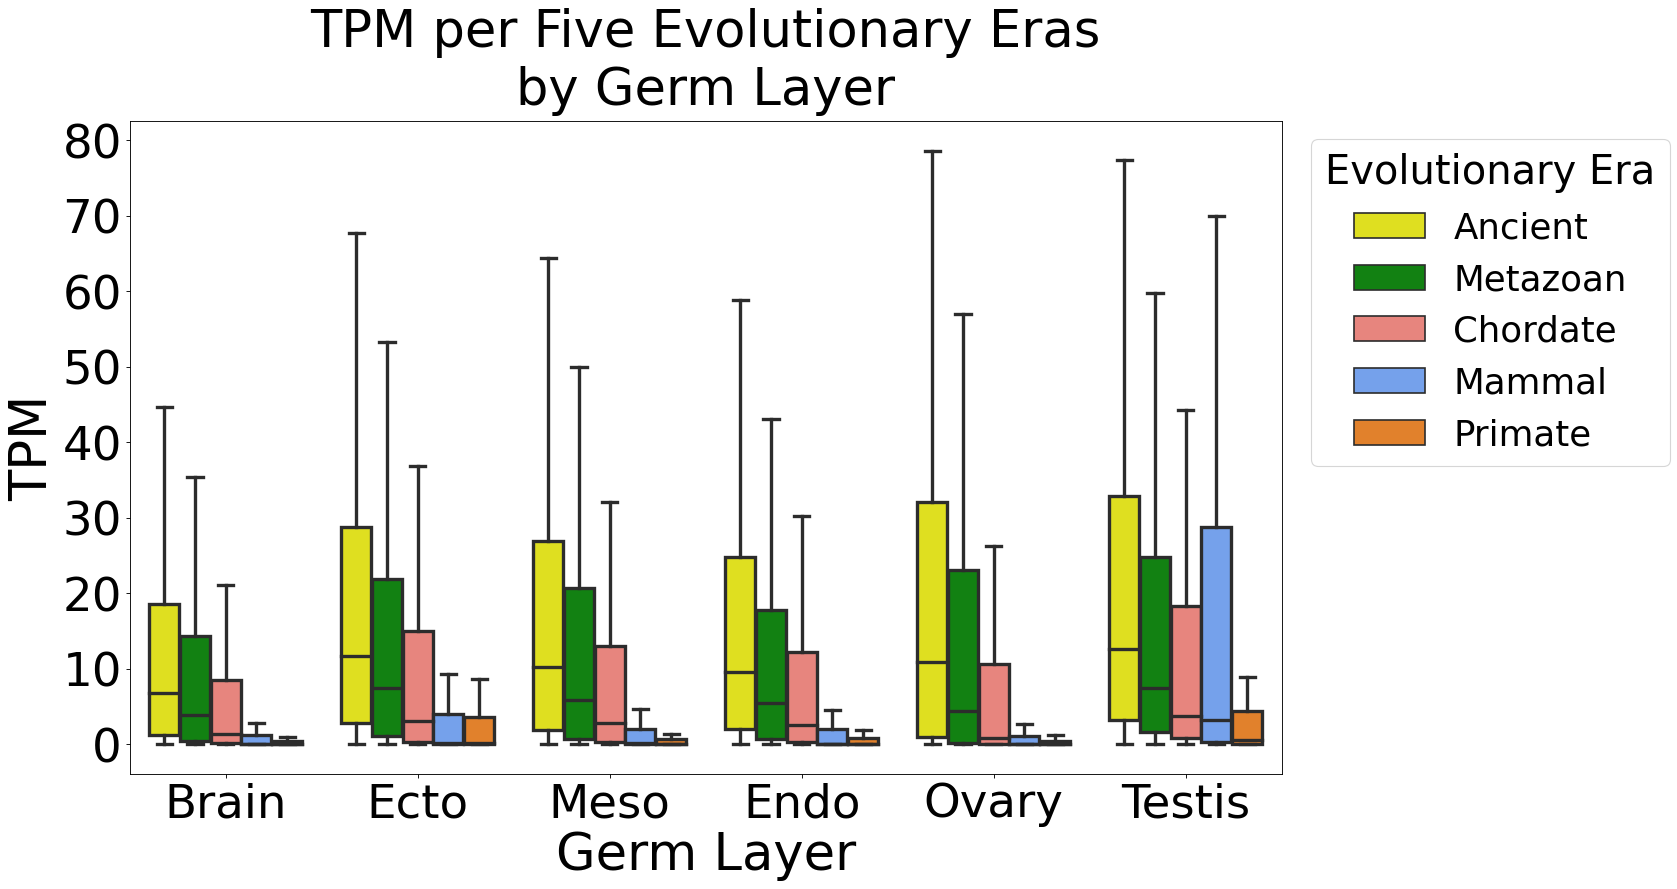

In [15]:
# PLOT SET #2

plt.figure(figsize=(18,12), dpi=80)
sns.boxplot(data=dermTidy.sort_values(by=['Derm','Era-5']),x='plot_derm',y='Mean(Count)',hue='plot_era5',showfliers=False,linewidth=3,palette=era_five_colours)
plt.xlabel('Germ Layer',size=46)
plt.ylabel('TPM',size=46)
plt.xticks(size=42)
plt.yticks(size=42)
plt.legend(bbox_to_anchor=(1.01, 1),title='Evolutionary Era',title_fontsize=36,fontsize=32)
plt.title('TPM per Five Evolutionary Eras\nby Germ Layer',size=46,pad=15)
plt.subplots_adjust(bottom=0.2,left=0.1)

image_name = f'fig2-tpm-per-five-eras-by-germ-metazoanlabelsize-{datename}'
plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/png/{image_name}_png.png',bbox_inches="tight")
plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/pdf/{image_name}_pdf.pdf',bbox_inches="tight")

plt.show()

In [16]:
dermTidy[dermTidy['Era-5']=='5-Primate']['Mean(Count)'].describe()

count     1002.000000
mean        56.381020
std        972.999479
min          0.000000
25%          0.000000
50%          0.080692
75%          1.117334
max      22110.900000
Name: Mean(Count), dtype: float64

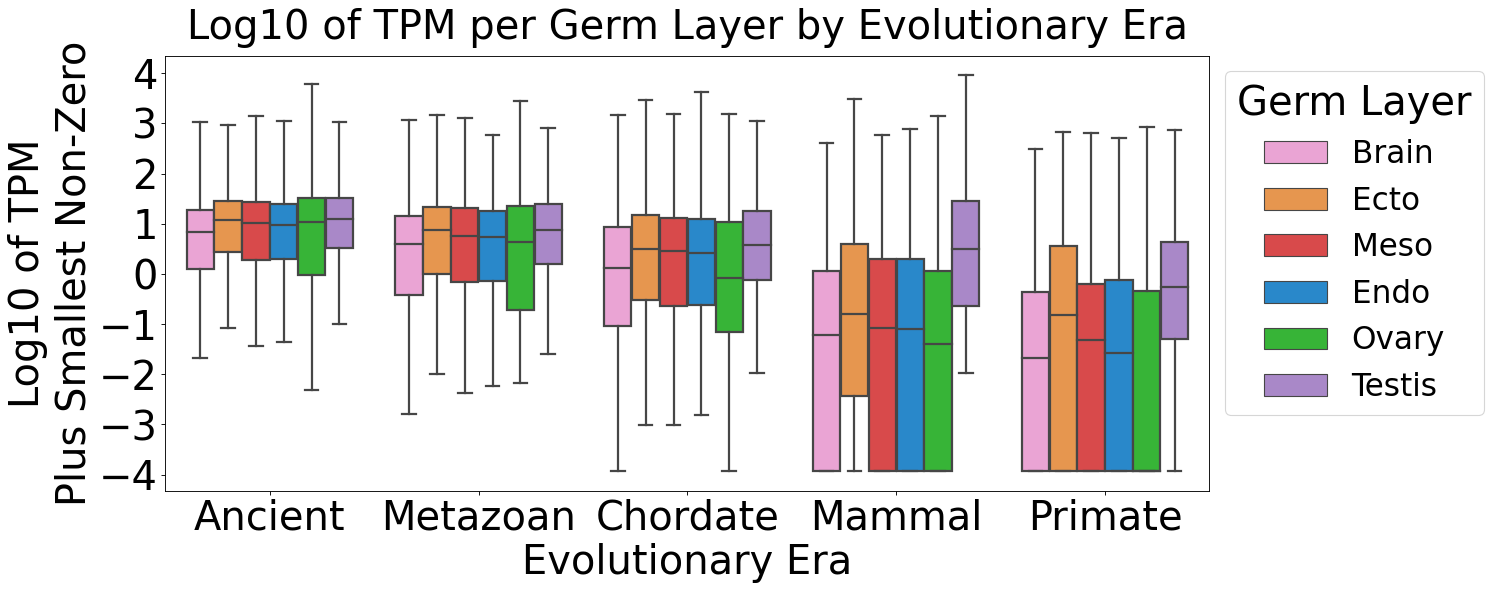

In [17]:
# PLOT SET #3 - Log10 of TPM per Germ Layer by Evolutionary Era

for config in ['plot_era5']:

    plt.figure(figsize=(18,8), dpi=80)
    # print(config)
    sns.boxplot(data=dermTidy.sort_values(by=['Era-5','Derm']).dropna(subset='Log10'),x=config,y='Log10',hue='plot_derm',showfliers=False,linewidth=2,palette=germ_colours)
    plt.xlabel('Evolutionary Era',size=36)
    plt.ylabel('Log10 of TPM\nPlus Smallest Non-Zero',size=36)
    xOnes,xTwos = plt.xticks()
    if config == 'plot_era5':
        xTwos[1] = 'Metazoan'

    plt.xticks(xOnes,xTwos,size=36)
    plt.yticks(size=36)
    plt.legend(title='Germ Layer',title_fontsize=36,fontsize=28,bbox_to_anchor=(1.00, 1))
    plt.title('Log10 of TPM per Germ Layer by Evolutionary Era',size=36,pad=15)
    plt.subplots_adjust(left=0.175,bottom=0.2)
    image_name = f'fig1-log10tpm-per-germ-by-{config}-smallestnonzero-metazoanlabelsize-{datename}'

    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/png/{image_name}_png.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/pdf/{image_name}_pdf.pdf',bbox_inches="tight")


    plt.show()

In [18]:
# cleaning to keep names consistent with some publication standards 
dermTidy['plot_era5'] = dermTidy['plot_era5'].replace('Metazoa','Metazoan')

In [19]:
# color changes
era_five_colours['Metazoan'] = (0.0, 0.5772549019607842, 0.0)

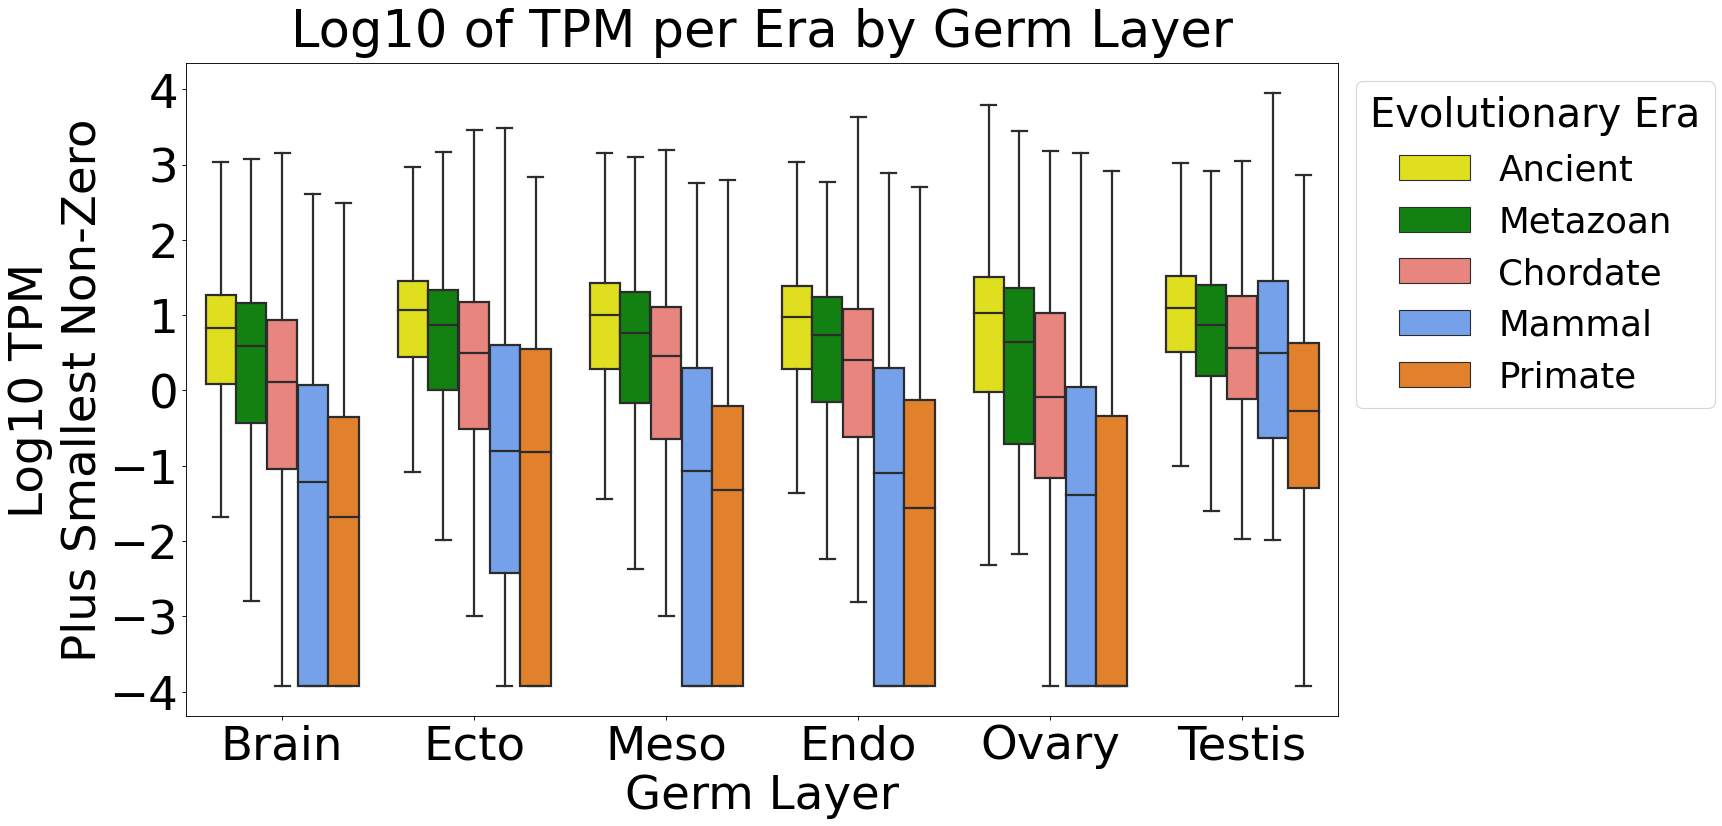

In [20]:
# PLOT SET #4 - Log10 of TPM per Era by Germ Layer

for config in ['plot_era5']:
    
    if config == 'plot_era5':
        paly = era_five_colours

    plt.figure(figsize=(18,12), dpi=80)
    sns.boxplot(data=dermTidy.sort_values(by=['Era-5','Derm']).dropna(subset='Log10'),x='plot_derm',y='Log10',hue=config,showfliers=False,linewidth=2,palette=paly)
    plt.xlabel('Germ Layer',size=42)
    plt.ylabel('Log10 TPM\nPlus Smallest Non-Zero',size=42)
    plt.xticks(size=42)
    plt.yticks(size=42)
    plt.legend(bbox_to_anchor=(1.00, 1),title='Evolutionary Era',title_fontsize=36,fontsize=32)
    plt.title('Log10 of TPM per Era by Germ Layer',size=46,pad=15)
    plt.subplots_adjust(bottom=0.2,left=0.1)
    
    image_name = f'fig2-log10tpm-log10-per-{config}-smallestnonzero-by-germ-metazoanlabelsize-{datename}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/png/{image_name}_png.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_tpms_{datename}/pdf/{image_name}_pdf.pdf',bbox_inches="tight")


    plt.show()